This is a fairly simple autoencoder but trained as a denoising autoencoder to reverse blurred inputs.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist, mnist
from tensorflow.keras.models import Model
from scipy.ndimage import gaussian_filter
import time

(x_train, _), (x_test, _) = fashion_mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

(mn_x_train, _), (mn_x_test, _) = mnist.load_data()
mn_x_train = mn_x_train.astype('float32') / 255.
mn_x_test = mn_x_test.astype('float32') / 255.

mn_x_train = mn_x_train[..., tf.newaxis]
mn_x_test = mn_x_test[..., tf.newaxis]

blur_x_train = np.zeros_like(x_train)
for i in range(mn_x_train.shape[0]):
    blur_x_train[i] = gaussian_filter(mn_x_train[i], sigma=4)
blur_x_test = np.zeros_like(x_test)
for i in range(mn_x_test.shape[0]):
    blur_x_test[i] = gaussian_filter(mn_x_test[i], sigma=4)

2023-09-26 11:17:23.203359: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-26 11:17:23.304505: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-26 11:17:24.106440: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
class CNNAuto(Model):
  def __init__(self):
    super(CNNAuto, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(28, 28, 1)),
      layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
      layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)])
    
    self.latent = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(64, activation='relu', activity_regularizer=tf.keras.regularizers.l1(1e-5))])

    self.decoder = tf.keras.Sequential([
      layers.Dense(392, activation='relu'),
      layers.Reshape((7,7,8)),
      layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')])

  def call(self, x):
    encoded = self.encoder(x)
    latent = self.latent(encoded)
    decoded = self.decoder(latent)
    return decoded

auto = CNNAuto()
auto.compile(optimizer='adam', loss=losses.MeanSquaredError())

2023-09-26 11:17:35.509443: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-26 11:17:35.559145: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-26 11:17:35.559618: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-26 11:17:35.564426: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-26 11:17:35.565003: I tensorflow/compile

In [3]:
auto.fit(blur_x_train, mn_x_train, epochs=10, shuffle=True)

Epoch 1/10


2023-09-26 11:17:49.930031: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-09-26 11:17:51.252722: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2023-09-26 11:17:51.842699: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f1ece545f40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-09-26 11:17:51.842761: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): Quadro RTX 4000, Compute Capability 7.5
2023-09-26 11:17:51.875906: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-09-26 11:17:52.176021: E tensorflow/compiler/xla/stream_executor/gpu/asm_comp

1875/1875 [==============================] - 14s 4ms/step - loss: 0.0427
Epoch 2/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0237
Epoch 3/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0210
Epoch 4/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0194
Epoch 5/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0181
Epoch 6/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0171
Epoch 7/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0162
Epoch 8/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0155
Epoch 9/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0149
Epoch 10/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0145


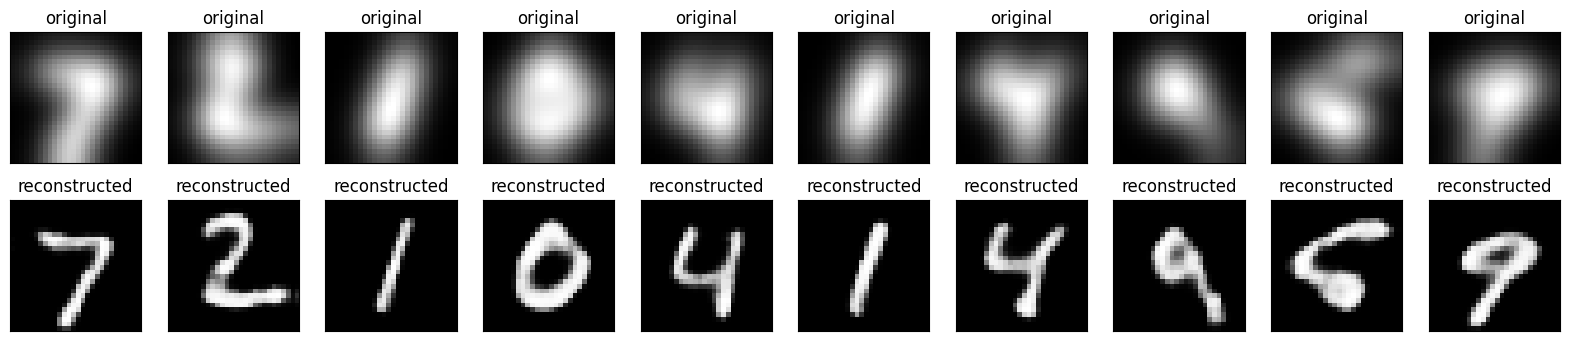

In [4]:
encoded_imgs = auto.encoder(blur_x_test[0:10,]).numpy()
latents = auto.latent(encoded_imgs).numpy()
decoded_imgs = auto.decoder(latents).numpy()
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):

    # display original + noise
    ax = plt.subplot(2, n, i + 1)
    plt.title("original")
    plt.imshow(tf.squeeze(blur_x_test[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()